# ICA Point Clouds Without Limbs

This script dismantles the myth that ICA requires limb- or cross-shaped point
clouds. We work with continuously active, overlapping sources, mix them, and
show that FastICA still recovers the underlying components.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import FastICA

TOPIC = "ica_pointclouds"
FIG_DIR = os.path.join("figures", TOPIC)
os.makedirs(FIG_DIR, exist_ok=True)

rng = np.random.default_rng(7)

## Source generators

Reusing simple distributions keeps the focus on geometry rather than model
complexity.

In [2]:
def laplace(size: int) -> np.ndarray:
    return rng.laplace(0.0, 1 / np.sqrt(2), size)


def logistic(size: int) -> np.ndarray:
    return rng.logistic(0.0, 1.0, size)


def uniform(size: int) -> np.ndarray:
    return rng.uniform(-1.0, 1.0, size)


def bimodal(size: int) -> np.ndarray:
    centers = rng.choice([-2.5, 2.5], size=size)
    return centers + rng.normal(0, 0.4, size=size)


def mix_sources(S: np.ndarray) -> np.ndarray:
    A = np.array([[1.5, -0.8], [0.4, 1.2]])
    return (A @ S.T).T


def compute_correlations(true_sources: np.ndarray, recovered: np.ndarray) -> np.ndarray:
    corr = np.zeros((true_sources.shape[1], recovered.shape[1]))
    ts = true_sources - true_sources.mean(axis=0, keepdims=True)
    rs = recovered - recovered.mean(axis=0, keepdims=True)
    ts_std = ts.std(axis=0, keepdims=True)
    rs_std = rs.std(axis=0, keepdims=True)
    ts_norm = ts / ts_std
    rs_norm = rs / rs_std
    for i in range(ts.shape[1]):
        for j in range(rs.shape[1]):
            corr[i, j] = np.mean(ts_norm[:, i] * rs_norm[:, j])
    return corr

## Example 1: Laplace + Logistic

These sources overlap everywhere, yet remain statistically independent.

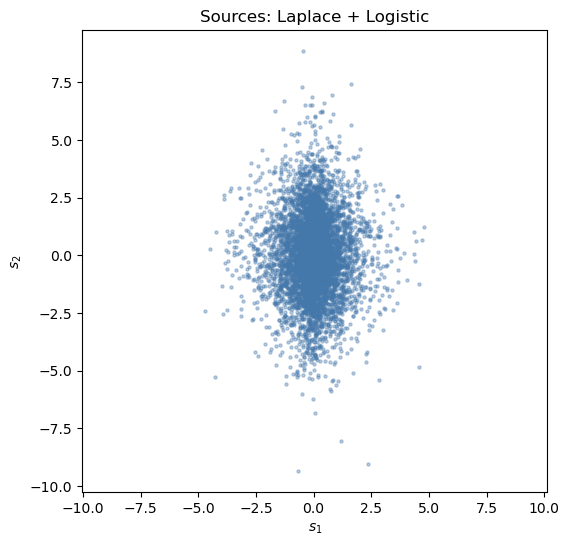

In [3]:
n_samples = 6000
S = np.column_stack([laplace(n_samples), logistic(n_samples)])

plt.figure(figsize=(6, 6))
plt.scatter(S[:, 0], S[:, 1], s=5, alpha=0.35, color="#4477aa")
plt.title("Sources: Laplace + Logistic")
plt.xlabel("$s_1$")
plt.ylabel("$s_2$")
plt.axis("equal")
plt.savefig(
    os.path.join(FIG_DIR, "sources_laplace_logistic.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

### Linear mixing

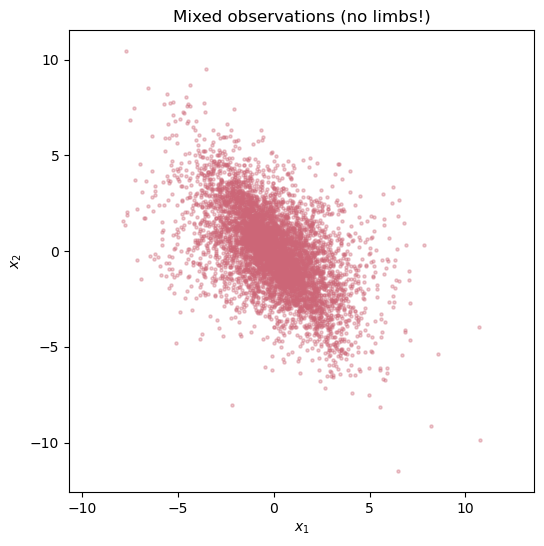

In [4]:
X = mix_sources(S)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=5, alpha=0.35, color="#cc6677")
plt.title("Mixed observations (no limbs!)")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis("equal")
plt.savefig(
    os.path.join(FIG_DIR, "mixed_laplace_logistic.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

### FastICA recovery

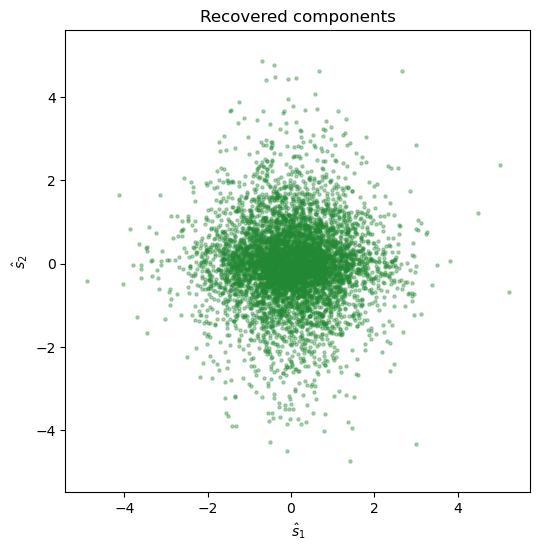

Correlation between true and recovered sources:
 [[ 0.004  1.   ]
 [-1.    -0.009]]


In [5]:
ica = FastICA(random_state=0, whiten="unit-variance")
S_hat = ica.fit_transform(X)

plt.figure(figsize=(6, 6))
plt.scatter(S_hat[:, 0], S_hat[:, 1], s=5, alpha=0.35, color="#228833")
plt.title("Recovered components")
plt.xlabel("$\\hat{s}_1$")
plt.ylabel("$\\hat{s}_2$")
plt.axis("equal")
plt.savefig(
    os.path.join(FIG_DIR, "recovered_laplace_logistic.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

corr_matrix = compute_correlations(S, S_hat)
print("Correlation between true and recovered sources:\n", np.round(corr_matrix, 3))

## Example 2: Bimodal + Uniform

Another pair of overlapping, non-limb sources reinforces the lesson.

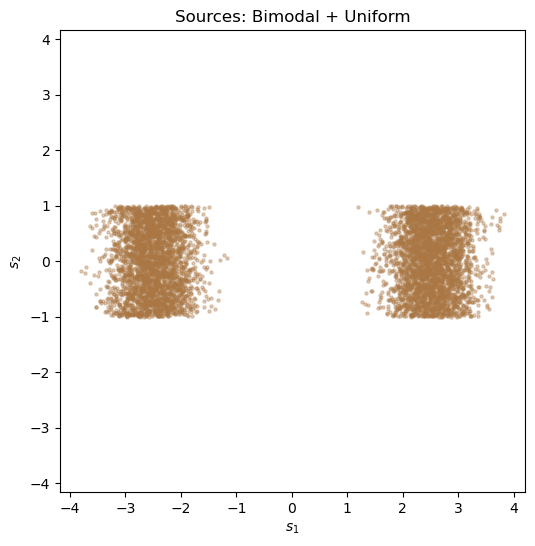

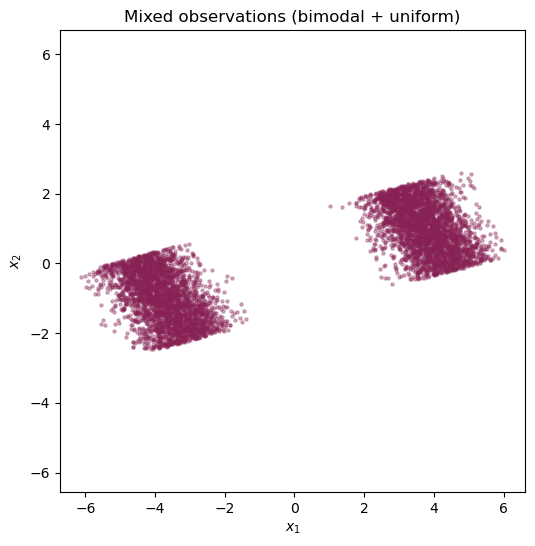

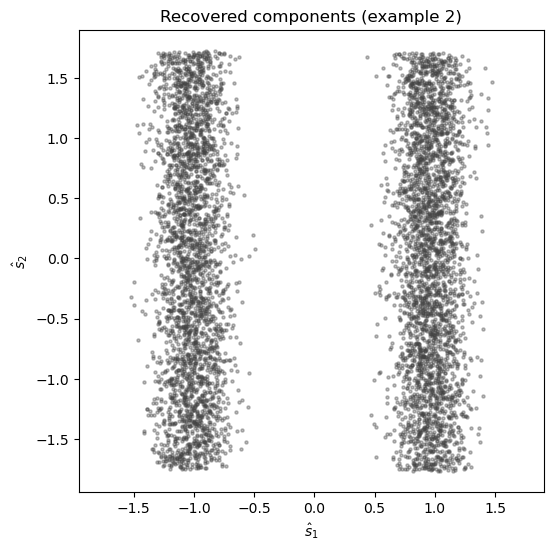

Correlation matrix (example 2):
 [[1.    0.004]
 [0.008 1.   ]]


In [6]:
S2 = np.column_stack([bimodal(n_samples), uniform(n_samples)])

plt.figure(figsize=(6, 6))
plt.scatter(S2[:, 0], S2[:, 1], s=5, alpha=0.35, color="#aa7744")
plt.title("Sources: Bimodal + Uniform")
plt.xlabel("$s_1$")
plt.ylabel("$s_2$")
plt.axis("equal")
plt.savefig(
    os.path.join(FIG_DIR, "sources_bimodal_uniform.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

X2 = mix_sources(S2)

plt.figure(figsize=(6, 6))
plt.scatter(X2[:, 0], X2[:, 1], s=5, alpha=0.35, color="#882255")
plt.title("Mixed observations (bimodal + uniform)")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis("equal")
plt.savefig(
    os.path.join(FIG_DIR, "mixed_bimodal_uniform.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

ica2 = FastICA(random_state=1, whiten="unit-variance")
S2_hat = ica2.fit_transform(X2)

plt.figure(figsize=(6, 6))
plt.scatter(S2_hat[:, 0], S2_hat[:, 1], s=5, alpha=0.35, color="#444444")
plt.title("Recovered components (example 2)")
plt.xlabel("$\\hat{s}_1$")
plt.ylabel("$\\hat{s}_2$")
plt.axis("equal")
plt.savefig(
    os.path.join(FIG_DIR, "recovered_bimodal_uniform.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

corr_matrix2 = compute_correlations(S2, S2_hat)
print("Correlation matrix (example 2):\n", np.round(corr_matrix2, 3))

## Summary

* Independence does not imply axis-aligned “limbs.”
* Linear mixing can obscure the original axes, yet FastICA recovers them.
* Non-Gaussianity + independence + linear mixing are the key ICA ingredients.